In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cols
import matplotlib.cm as cm

SingleDim = 9
UNOCCUPIED = 0

board = np.zeros(shape=(SingleDim,SingleDim), dtype=int)
board[[2,2,2,2,3],[4,5,6,7,2]] = 6
board[[4,5,6,7,1],[2,3,4,5,7]] = 7

vacant = board == UNOCCUPIED

vacant_i = np.array(list(zip(*np.nonzero(vacant))))
v2 = vacant_i.copy()
np.random.shuffle(v2)
v2 = v2[:28]

In [13]:
board[v2[:,0], v2[:,1]] = np.random.randint(1,8,len(v2)) #[7,2,3,4,5,5,7,2,3,4,5,5,1,1]

In [14]:
def drawBoard(board):
    lines_cm = cols.ListedColormap([[1, 0, 0],
                                   [0, 1, 0],
                                   [0, 0, 1],
                                   [0, 1, 1],
                                   [1, 1, 0],
                                   [1, 0, 1],
                                   [.8,.52,.25]])

    x,y = np.nonzero(board != UNOCCUPIED)
    fig = plt.figure(figsize=(SingleDim,SingleDim), dpi=75)
    ax = plt.subplot(111, aspect='equal', xlim=[0,SingleDim], ylim=[0,SingleDim], 
                     xticks=range(SingleDim+1), yticks=range(SingleDim+1))
    ax.grid(True)
    ax.scatter(y+0.5, x+0.5, s=2000, c=[board[x1,y1] for x1,y1 in zip(x,y)], 
               cmap=lines_cm)

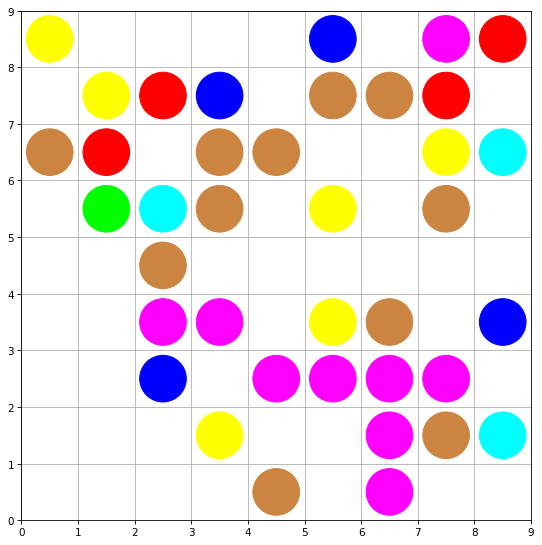

In [15]:
drawBoard(board)

In [30]:
from itertools import product, islice
from dijkstar import Graph, find_path

graph = Graph()
for disp in [(1,0), (0,1), (-1,0), (0,-1)]:
    if disp[0] != 0 :
        row_plus = (1-disp[0])//2
    else:
        row_plus = 0
    if disp[1] != 0 :
        col_plus = (1-disp[1])//2
    else:
        col_plus = 0

    for r,c in product(range(row_plus, min(SingleDim,SingleDim-disp[0])), 
                       range(col_plus, min(SingleDim,SingleDim-disp[1]))):
        loc = (r,c)
        adj_loc = (loc[0]+disp[0],loc[1]+disp[1])
        graph.add_edge(loc, adj_loc, (loc,adj_loc))

costFunction = lambda u,v,e,pe: 0.001+int(board[v]!=UNOCCUPIED)

def getPath(board, src, dst):
    return find_path(graph, src, dst, cost_func=costFunction)

In [17]:
MIN_LINE_ELIMINATION_SIZE = 5
ERROR_REWARD = -5
orig_dirs = [(-1,0),(-1,-1),(0,-1),(1,-1)]
isInRange = lambda loc: np.all(np.array(loc)>=0) and np.all(np.array(loc)<SingleDim)

def getStraitConnection(board, location, color):
    connection = []
    for shift in orig_dirs:
        line = []
        
        loc = location
        while True:
            loc = (loc[0]+shift[0], loc[1]+shift[1])
            if not isInRange(loc) or board[loc] != color: break
            line.append(loc)
        #print(line)
            
        loc = location
        while True:
            loc = (loc[0]-shift[0], loc[1]-shift[1])
            if not isInRange(loc) or board[loc] != color: break
            line.append(loc)
        #print(line)
        
        if len(line) >= MIN_LINE_ELIMINATION_SIZE-1:
            connection.extend(line)
    
    #if len(connection) > 0: connection.append(location)
    return connection
    
def getLinesTransition(board, src, dst):
    err = (board, ERROR_REWARD)
    c = board[src]
    if c == UNOCCUPIED: return err
    path = getPath(board, src, dst)
    if path.total_cost > 1.0: return err
    
    conn = np.array(getStraitConnection(board, dst, c))
    
    b = board.copy()
    b[src] = UNOCCUPIED
    reward = len(conn)
    if reward > 0:
        b[conn[:,0],conn[:,1]] = UNOCCUPIED
        reward += 1
    else:
        b[dst] = c
    return (b, reward)

In [24]:
from dijkstar.algorithm import single_source_shortest_paths

def getPathsFrom(src):
    return single_source_shortest_paths(graph, src, cost_func=costFunction)

In [25]:
paths = getPathsFrom((0,6))
[(k,v[2]) for k,v in paths.items() if v[2]!=None and v[2]<1.0]

[((0, 7), 0.001),
 ((0, 5), 0.001),
 ((0, 8), 0.002),
 ((1, 5), 0.002),
 ((1, 4), 0.003)]

In [35]:
def getActionsIter(board):
    occupied_i = list(zip(*np.nonzero(board != UNOCCUPIED)))
    for src in occupied_i:
        paths = getPathsFrom(src)
        reachable = [(k,v[2]) for k,v in paths.items() if v[2]!=None and v[2]<1.0]
        for node in reachable:
            yield (src,node[0])

In [93]:
acts = getActionsIter(board)

i = int(np.random.randint(0,399,1)[0])
src,dst = list(islice(acts, i, i+1))[0]
next_board, reward = getLinesTransition(board, src, dst)
reward, src, dst

(5, (7, 6), (8, 6))

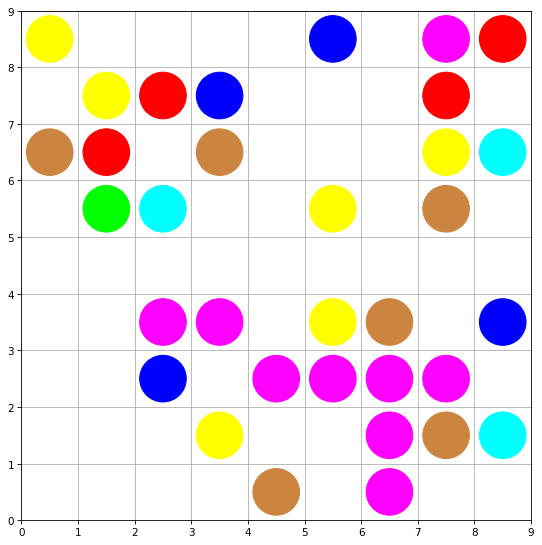

In [94]:
drawBoard(next_board)

In [61]:
i = int(np.random.randint(0,90,1)[0])
list(islice(acts, i, i+1))[0]

((7, 7), (7, 8))